In [1]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('up');
Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('down');

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import random

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
data_train_x = pd.read_csv("train-1541136939101.csv")
data_test = pd.read_csv("test-1541136939101.csv")
y_train = pd.read_csv("trainlabels-1541136939101.csv")

In [4]:
print(data_train_x.shape)
print(y_train.shape)
print(data_test.shape)

(44068, 34)
(44068, 2)
(11015, 34)


In [5]:

data_train = pd.concat([data_train_x.set_index('Id'),y_train.set_index('id')], axis=1, join='inner').reset_index()
#data_train['index'] = 'Id'
data_train.rename(columns={'index':'Id',},inplace=True)

data_train_x = pd.concat([data_train_x.set_index('Id'),y_train.set_index('id')], axis=1, join='inner').reset_index()
data_train_x.rename(columns={'index':'Id',},inplace=True)

#Adding the test dataset to train#
data_train = data_train.append(data_test, ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [6]:
data_train.shape

(55083, 35)

In [7]:
data_train.Id.value_counts().head()
#This represents that the ID are unique there are no multiple data collection of single well

2047     1
8721     1
53775    1
49677    1
51724    1
Name: Id, dtype: int64

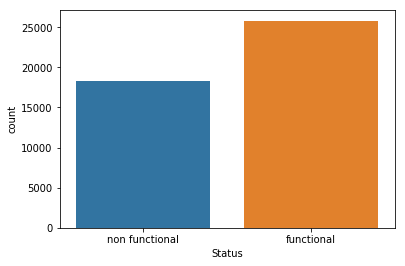

In [8]:
freq_y = data_train_x.Status.value_counts()
freq_y_df = pd.DataFrame(freq_y.reset_index())
freq_y_df.Status.sum()
sns.countplot(x="Status", data=data_train)

In [9]:
print("the percentage of Functional records are",freq_y_df.Status[0]/freq_y_df.Status.sum() *100)
print("the percentage of Non-Functional records are",freq_y_df.Status[1]/freq_y_df.Status.sum() *100)
#This tells that the data is not too imbalanced and we can approach wither with down-sampling.

the percentage of Functional records are 58.56403739675048
the percentage of Non-Functional records are 41.43596260324952


In [10]:
freq_y

functional        25808
non functional    18260
Name: Status, dtype: int64

## Working out on NA values

In [11]:
data_train.isna().sum()
#six columns with one column having more than 50% NA 
#whereas all the other columns have around 7% which can be imputed

Amount_of_water              0
Basin_name                   0
Company_installed         2603
District_code                0
Extraction_type              0
Extraction_type_class        0
Extraction_type_group        0
Gps_height                   0
Id                           0
Management                   0
Management_group             0
Organization_funding      2600
Organization_surveyed        0
Payment                      0
Payment_type                 0
Permit                    2756
Population                   0
Public_meeting            3178
Quality_group                0
Quantity                     0
Quantity_group               0
Region_code                  0
Regionname                   0
SchemeName               26162
Scheme_management         3654
Source                       0
Source_class                 0
Source_type                  0
Status                   11015
Village                      0
Wardname                     0
Water_quality                0
Waterpoi

In [12]:
data_train.drop("SchemeName",inplace=True,axis=1)  #This column contains high amount of NA values hance discarding

In [13]:
print(data_train.Public_meeting.value_counts())
print("The number of NA values in Public_meeting column:",data_train.Public_meeting.isna().sum())

True     47292
False     4613
Name: Public_meeting, dtype: int64
The number of NA values in Public_meeting column: 3178


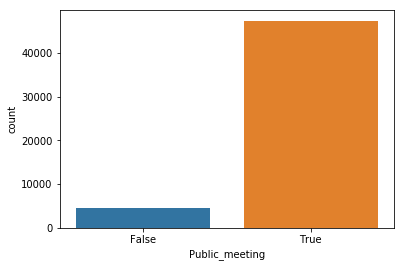

In [14]:
sns.countplot(x="Public_meeting", data=data_train)
#Imbalanced class this means we can impute NA with True

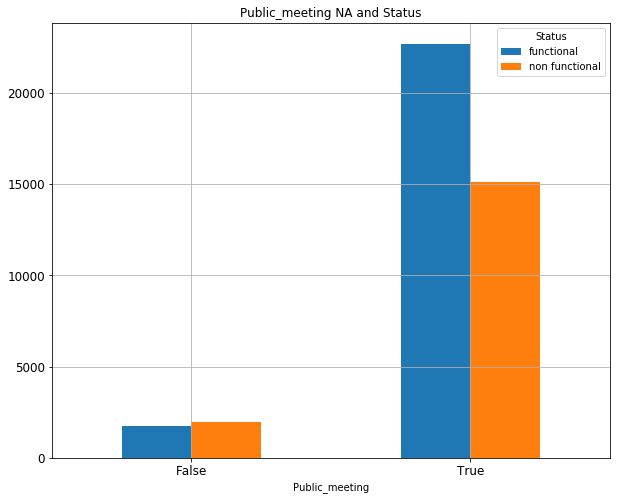

In [15]:
train_public_meeting = data_train.groupby(['Public_meeting','Status']).size()
train_public_meeting_stack = train_public_meeting.unstack(1).fillna('0')
train_public_meeting_stack.plot(kind='bar',figsize=(10,8),
                                   title='Public_meeting NA and Status',grid=True,legend='True',
                                   fontsize=12, rot='horizontal')

#By digging deeper, if public_meeting is true then 60% of the time it is functional.
#So placing True where the Status is functional and true where the status is non-functional is 
#going to help

In [16]:
data_train['Public_meeting'] = data_train.fillna(data_train['Public_meeting'].value_counts().index[0])

### Organization Funding

In [17]:
data_train.Organization_funding.nunique()
#There are way too many classes to build model on.
#So we will not be considering this for model building

2632

In [18]:
data_train.drop("Organization_funding",axis=1, inplace=True)

### Scheme Management

In [19]:
data_train.Scheme_management.nunique()

12

In [20]:
data_train.Scheme_management.value_counts()

VWC                 34459
WUG                  4534
Water authority      2705
WUA                  2644
Water Board          2637
Parastatal           1478
Private operator     1040
Company              1024
Other                 744
SWC                    96
Trust                  67
None                    1
Name: Scheme_management, dtype: int64

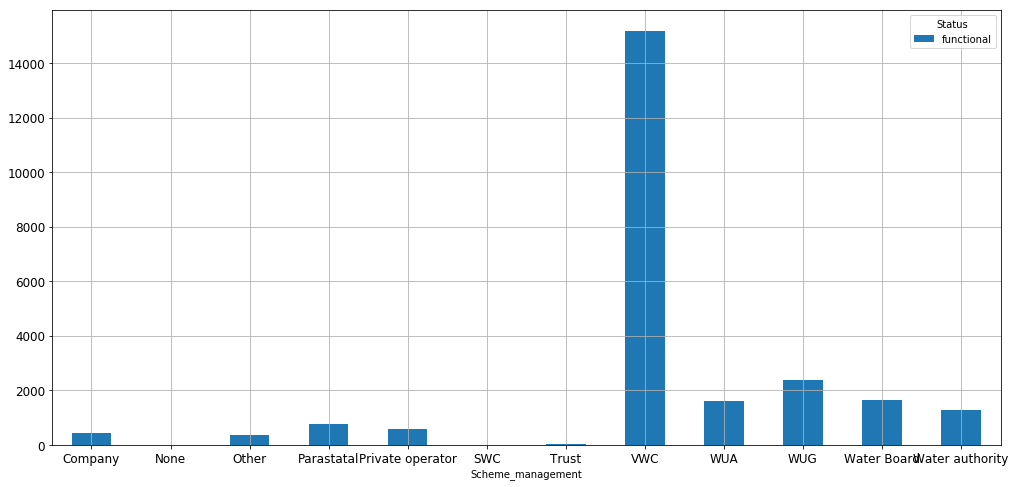

In [21]:
train_scheme_management = data_train.groupby(['Scheme_management','Status']).size()
train_scheme_management_stack = train_scheme_management.unstack(1).fillna('0')
train_scheme_management_stack.plot(kind='bar',figsize=(17,8)
                                ,grid=True,legend='True',
                                   fontsize=12, rot='horizontal')

#This is an interesting pattern.
#All scheme management records are under functional. This means that the records that have NA in scheme management
#are not functional. So we can assign None to tha NA records

In [22]:
data_train.Scheme_management.value_counts()

VWC                 34459
WUG                  4534
Water authority      2705
WUA                  2644
Water Board          2637
Parastatal           1478
Private operator     1040
Company              1024
Other                 744
SWC                    96
Trust                  67
None                    1
Name: Scheme_management, dtype: int64

In [23]:
data_train= data_train.fillna(data_train.Scheme_management.value_counts().index[11])

### Permit

In [24]:
data_train.Permit.nunique()

3

In [25]:
data_train.Permit.value_counts()

True     36155
False    16172
None      2756
Name: Permit, dtype: int64

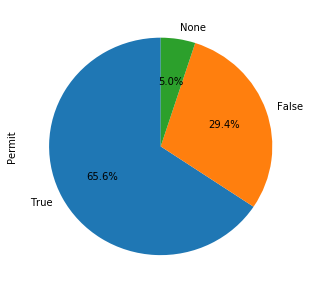

In [26]:
plot = data_train.Permit.value_counts().plot.pie(y='Permit', figsize=(5, 5), startangle=90, autopct='%.1f%%')

In [27]:
data_train.Status.value_counts()

functional        25808
non functional    18260
None              11015
Name: Status, dtype: int64

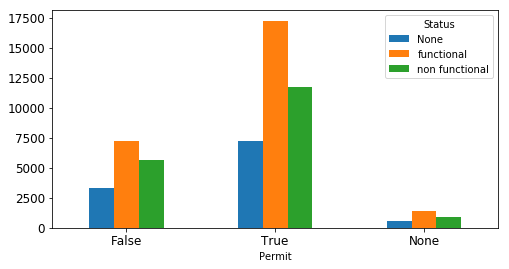

In [28]:
train_permit = data_train.groupby(['Permit','Status']).size()
train_permit_stack = train_permit.unstack(1).fillna('0')
train_permit_stack.plot(kind='bar',figsize=(8,4),
                                   legend='True',
                                   fontsize=12, rot='horizontal')

In [29]:
#We will go by replacing it randomly
data_train = data_train.fillna(data_train['Permit'].value_counts().index[0])

### Company_installed

In [30]:
#Company_installed Column
print("The number of unique companies present are:",data_train.Company_installed.nunique())
print("Companies that created most wells:",data_train.Company_installed.value_counts().head())
#This clearly states that the companies are many and the project is allocated to different firms 

The number of unique companies present are: 2646
Companies that created most wells: Iorg1388    14168
None         2603
IORG1388     2376
Iorg1510     1468
Iorg504      1016
Name: Company_installed, dtype: int64


In [31]:
data_company_installed = pd.DataFrame(data_train.Company_installed.value_counts().head())
print("Top 5 companies based on number of wells created:",data_train.Company_installed.value_counts().head().sum())

Top 5 companies based on number of wells created: 21631


In [32]:
data_train_comapny_installed = pd.DataFrame(data_train.Company_installed.value_counts().head())
data_train_comapny_installed

,Company_installed
Iorg1388,14168
None,2603
IORG1388,2376
Iorg1510,1468
Iorg504,1016


In [33]:
#We can neglect this column as this has many companies 
data_train.drop("Company_installed",inplace=True,axis=1)

## Formatting the data

In [34]:
categoricalFeatureNames =["Waterpointname","Waterpoint_type","Basin_name","Village",
                         "Regionname","Region_code","Wardname","District_code","Management",
                         "Management_group","Extraction_type","Extraction_type_group",
                         "Extraction_type_class","Payment","Payment_type","Water_quality","Quality_group","Quantity_group",
                         "Source","Source_type","Source_class","Waterpoint_type_group","Status","Quantity"]

for var in categoricalFeatureNames:
    data_train[var] = data_train[var].astype("category")
    
NumericalFeatureNames = ["Amount_of_water","Gps_height","Population"]


for var in NumericalFeatureNames:
    data_train[var] = data_train[var].astype("float")

In [35]:
for c in categoricalFeatureNames:
    print("%s ---" % c,data_train[c].nunique())
#From this we can rule out Waterpointname, Village, Wardname as these columns create more dummies and
#having so large numbers wont help

Waterpointname --- 35005
Waterpoint_type --- 7
Basin_name --- 9
Village --- 18483
Regionname --- 21
Region_code --- 27
Wardname --- 2090
District_code --- 20
Management --- 12
Management_group --- 5
Extraction_type --- 18
Extraction_type_group --- 13
Extraction_type_class --- 7
Payment --- 7
Payment_type --- 7
Water_quality --- 8
Quality_group --- 6
Quantity_group --- 5
Source --- 10
Source_type --- 7
Source_class --- 3
Waterpoint_type_group --- 6
Status --- 3
Quantity --- 5


In [36]:
data_train.drop(["Waterpointname","Village","Wardname"],axis=1, inplace=True)

## Checking data present in each columna

In [37]:
for c in data_train.columns:
    if data_train[c].dtype.name =='category':
        print("%s ---" % c,data_train[c].value_counts())

Basin_name --- basin5    9259
basin6    8463
basin7    7539
basin1    7228
basin9    5718
basin4    5690
basin2    4835
basin8    4167
basin3    2184
Name: Basin_name, dtype: int64
District_code --- 1     10916
2     10329
3      9299
4      8490
5      4162
6      3842
7      3129
8       990
30      909
33      776
53      719
43      497
13      362
23      267
63      190
62      109
60       60
0        21
80       11
67        5
Name: District_code, dtype: int64
Extraction_type --- gravity                      24079
nira/tanira                   7513
other                         6224
submersible                   4537
swn 80                        3458
mono                          2736
india mark ii                 2321
afridev                       1728
ksb                           1389
other - rope pump              434
other - swn 81                 222
windmill                       110
india mark iii                  97
other - play pump               84
cemo             

## Numeric Data

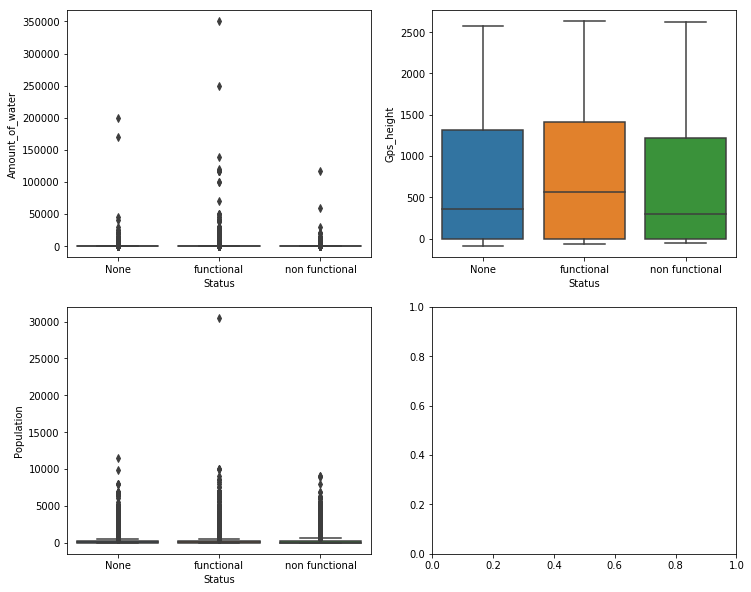

In [38]:
fig, axes = plt.subplots(nrows=2,ncols=2)

fig.set_size_inches(12, 10)

sns.boxplot(data=data_train,y="Amount_of_water",x='Status',orient="v",ax=axes[0][0]) 
sns.boxplot(data=data_train,y="Gps_height",x='Status',orient="v",ax=axes[0][1])
    
sns.boxplot(data=data_train,y="Population",x="Status",orient="v",ax=axes[1][0])



C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


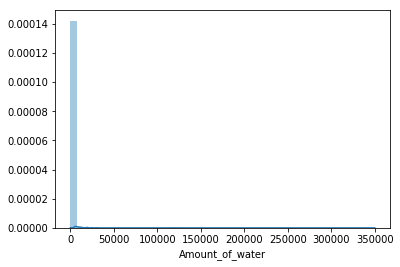

In [39]:
sns.distplot(data_train.Amount_of_water)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


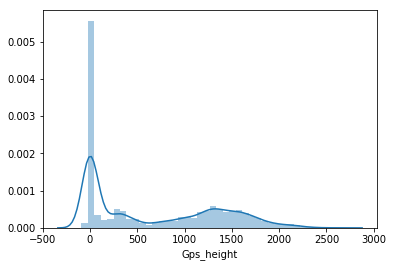

In [40]:
sns.distplot(data_train.Gps_height)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


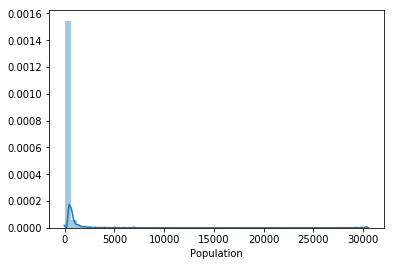

In [41]:
sns.distplot(data_train.Population)

In [42]:
#combining train and test data to do standardizing for numerical attributes
yy =  data_train[['Population','Gps_height','Amount_of_water']]

from sklearn import preprocessing
x = yy.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = ['Population','Gps_height','Amount_of_water']
#f#f['Population'] = df['Population']
#f#f['Gps_height'] = df['Gps_height']
#ff['Amount_of_water'] = df['Amount_of_water']
#jj = ff.head(2648)
#jj.shape

### Standardized data

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


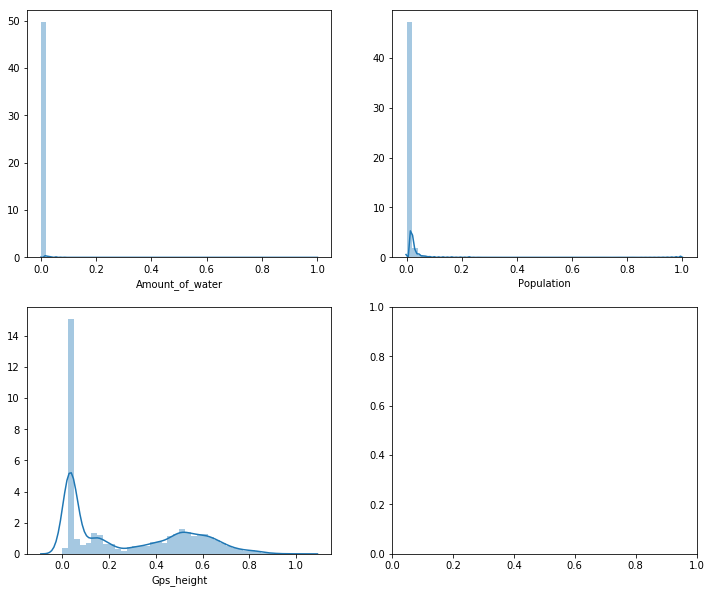

In [43]:
fig, axes = plt.subplots(nrows=2,ncols=2)

fig.set_size_inches(12, 10)

sns.distplot(df.Amount_of_water,ax=axes[0][0]) 
sns.distplot(df.Gps_height,ax=axes[1][0]) 
sns.distplot(df.Population,ax=axes[0][1]) 



In [44]:
data_train.Public_meeting.value_counts()

0.00         38591
500.00        2828
50.00         2365
1000.00       1402
20.00         1387
200.00        1100
10.00          790
100.00         756
30.00          708
2000.00        673
300.00         499
5000.00        416
250.00         415
5.00           376
25.00          338
3000.00        296
1200.00        253
6.00           187
1500.00        187
4000.00        146
2400.00        142
2500.00        135
6000.00        121
600.00         104
7.00            69
40.00           58
8000.00         57
10000.00        56
750.00          50
12000.00        48
             ...  
16300.00         2
11000.00         2
26000.00         2
100000.00        2
13000.00         2
800.00           2
16000.00         2
0.25             1
59.00            1
26.00            1
12.00            1
350000.00        1
9.00             1
306.00           1
138000.00        1
5400.00          1
70000.00         1
900.00           1
200000.00        1
120000.00        1
1400.00          1
250000.00   

In [45]:
data_train.columns

Index(['Amount_of_water', 'Basin_name', 'District_code', 'Extraction_type',
       'Extraction_type_class', 'Extraction_type_group', 'Gps_height', 'Id',
       'Management', 'Management_group', 'Organization_surveyed', 'Payment',
       'Payment_type', 'Permit', 'Population', 'Public_meeting',
       'Quality_group', 'Quantity', 'Quantity_group', 'Region_code',
       'Regionname', 'Scheme_management', 'Source', 'Source_class',
       'Source_type', 'Status', 'Water_quality', 'Waterpoint_type',
       'Waterpoint_type_group'],
      dtype='object')

In [46]:
data_dummies = data_train[["Waterpoint_type","Basin_name","Management_group","Region_code","Permit",
                       "Extraction_type_class","Extraction_type_group","Payment","Quality_group","Source_type","Quantity",
                          "Water_quality","Source_class"]]

In [47]:
data_train.Quantity.value_counts()

enough          30786
insufficient    13679
dry              6209
seasonal         3634
unknown           775
Name: Quantity, dtype: int64

In [48]:
dummies = pd.get_dummies(data_dummies)

In [49]:
dummies_num = dummies
dummies_num['Amount_of_water'] = df.Amount_of_water
dummies_num["Gps_height"] = df.Gps_height
dummies_num['Population']= df.Population
dummies_num['Status']= data_train.Status
data_for_model = dummies_num

In [50]:
real_test_data = data_for_model.tail(11015)
data_for_model.drop(data_for_model.tail(11015).index, inplace=True)

In [51]:
#data_for_model = data_for_model.fillna(data_for_model.mean())
data_for_model['Status'] = data_for_model['Status'].map({'functional': 1, 'non functional':0})
train_y = data_for_model["Status"]
data_for_model.drop("Status",axis=1, inplace=True)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(data_for_model, train_y, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(33051, 110)
(11017, 110)
(33051,)
(11017,)


# Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier(n_estimators=700)
RF_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [54]:
#predicting on train and test data
y_rf_pred_test = RF_clf.predict(X_test)
y_rf_pred_train = RF_clf.predict(X_train)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_rf_pred_test))
print(metrics.accuracy_score(y_test, y_rf_pred_test))

             precision    recall  f1-score   support

          0       0.83      0.75      0.79      4607
          1       0.83      0.89      0.86      6410

avg / total       0.83      0.83      0.83     11017

0.8322592357266043


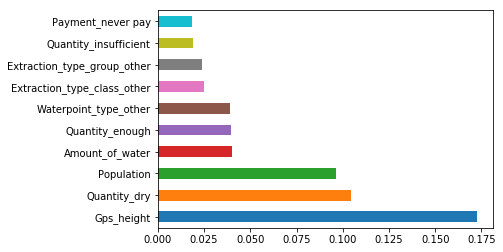

In [55]:
feat_importances = pd.Series(RF_clf.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)
feat_importances.nlargest(10).plot(kind='barh')

## Predicting on Real Test data

In [56]:
real_test_data.drop("Status",axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [57]:
RF_clf.predict(real_test_data)

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [58]:
probs_rf = RF_clf.predict_proba(real_test_data)
probs = probs_rf[:,1]  #taking a column
probs[probs > 0.5] =1  #setting thresholds
probs[probs <= 0.5] = 0
submission = data_test[["Id"]]
submission['Status'] = probs
submission['Status'] = submission['Status'].map({1:"functional",0:"non functional"})
submission.to_csv("predictions_naveen_gandla.csv",index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


# Random Forest with Hyper parameter tuning

In [74]:
from sklearn.model_selection import RandomizedSearchCV
model_tree_tuned=DecisionTreeClassifier()
param_grid={"max_leaf_nodes":np.arange(5,30,1),
            'min_samples_split': np.arange(0.001,0.1,0.001),
            'max_depth':np.arange(5,50,1),
            'min_weight_fraction_leaf':np.arange(0.01,0.25,0.005)}
rsearch = RandomizedSearchCV(estimator=model_tree_tuned, param_distributions=param_grid,n_iter=500)
rsearch.fit(X_train,y_train)
print(rsearch.best_score_)
print(rsearch.best_estimator_)
print("train Acuuracy",rsearch.score(X_train,y_train))
print('Test Accuracy',rsearch.score(X_test, y_test))

0.7662703095216483
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=27,
            max_features=None, max_leaf_nodes=23,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.014000000000000002,
            min_weight_fraction_leaf=0.01, presort=False,
            random_state=None, splitter='best')
train Acuuracy 0.7680554294877613
Test Accuracy 0.769719524371426


### Logistic Regression

In [59]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
seed=12
logreg = LogisticRegression(C=1, random_state=12, class_weight='balanced')

In [60]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=12,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

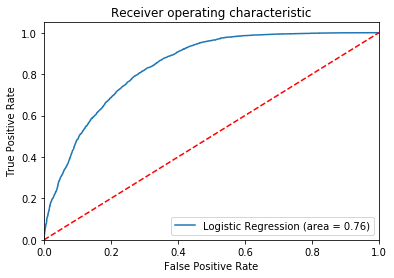

In [61]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(train_y, logreg.predict_proba(data_for_model)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [75]:
y_log_pred_train = logreg.predict(X_train)
ii = logreg.predict_proba(X_test)
probs_log = ii[:,1]  #taking a column
probs_log[probs_log > 0.6] =1  
probs_log[probs_log <= 0.60] = 0
y_log_pred_test = logreg.predict(X_test)
y_log_pred_train=logreg.predict(X_train)
print(classification_report(y_test, probs_log))

             precision    recall  f1-score   support

          0       0.66      0.78      0.72      4607
          1       0.82      0.71      0.76      6410

avg / total       0.75      0.74      0.74     11017



In [76]:
print(metrics.accuracy_score(y_test, y_log_pred_test))
print(metrics.accuracy_score(y_train,y_log_pred_train))

0.7668149223926659
0.7738041209040574


# Xgboost

In [66]:
import xgboost as xgb
from xgboost import XGBClassifier
model_xgb=XGBClassifier(n_estimators=300,random_state=1,learning_rate=0.5)
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [67]:
print("Train accuracy is ",metrics.accuracy_score(y_train,model_xgb.predict(X_train)))
print("Test accuracy is",metrics.accuracy_score(y_test,model_xgb.predict(X_test)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train accuracy is  0.8485371093159058
Test accuracy is 0.8195516020695289


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# ADABOOST

In [68]:
from sklearn.ensemble import AdaBoostClassifier
model_ada=AdaBoostClassifier(random_state=1,n_estimators=300,learning_rate=0.5)
model_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=300, random_state=1)

In [70]:
print("train accuracy" , metrics.accuracy_score(y_train,model_ada.predict(X_train)))
print("test accuracy", metrics.accuracy_score(y_test,model_ada.predict(X_test)))

train accuracy 0.7825481831109498
test accuracy 0.778705636743215


In [ ]:
# out of all the models XGBOOST and Random Forest are giving best Acuuracy 